# Fraud Detection Project - Comprehensive Analysis

This notebook provides a  summary of our fraud detection project, including data analysis, model comparisons, and key findings.

In [48]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Set style for better visualizations
plt.style.use('default')
sns.set_palette('husl')

# Import helper functions
import sys
sys.path.append('../')
from src.Helper_functions import plot_roc_curve, plot_pr_curve

## 1. Data Analysis
We begin by loading the dataset and examining its structure. The dataset contains anonymized features (V1-V28), the transaction amount, and a binary target variable indicating fraud. We check the class distribution to confirm the expected imbalance, and review summary statistics to understand the range and distribution of transaction amounts.

In [74]:
# Load the dataset
data = pd.read_csv('../creditcard.csv')

# Basic dataset information
print("Dataset Shape:", data.shape)
print("\nClass Distribution:")
print(data['Class'].value_counts(normalize=True).round(4))

# Display basic statistics
print("\nBasic Statistics:")
display(data.describe().round(2))

Dataset Shape: (284807, 31)

Class Distribution:
Class
0    0.9983
1    0.0017
Name: proportion, dtype: float64

Basic Statistics:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,...,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,94813.86,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,...,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,...,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,...,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,...,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,...,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,...,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


## 2. Data Visualization
The distribution of transaction amounts in the dataset is highly skewed, with a small number of extremely large transactions. While these high-value outliers are important for certain analyses, they can dominate the scale of visualizations and obscure the patterns present in the vast majority of transactions.

To provide a clearer and more interpretable view of typical transaction behavior, we limited the visualization to amounts below the 95th percentile. This approach allows us to highlight the structure and differences between legitimate and fraudulent transactions within the range where most activity occurs, without the distortion caused by extreme values.


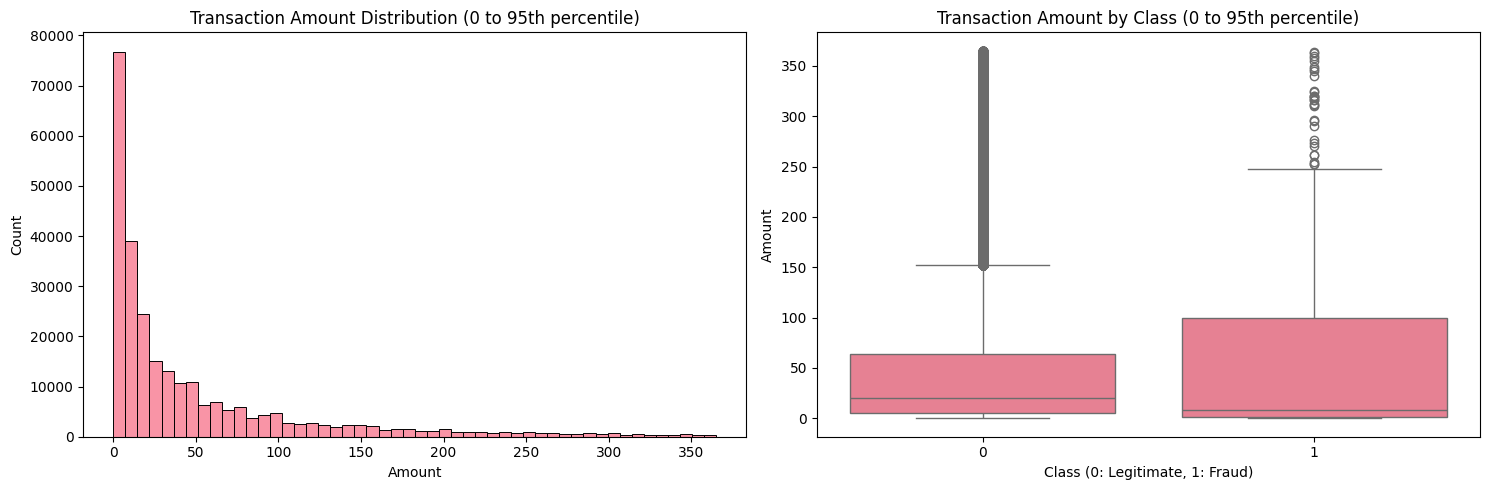


Transaction amount statistics by class:
         mean  median  min       max
Class                               
0       88.29   22.00  0.0  25691.16
1      122.21    9.25  0.0   2125.87

Class Distribution:
Class
0    284315
1       492
Name: count, dtype: int64


In [76]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Transaction Amount Distribution
upper = data['Amount'].quantile(0.95)

# Filter data to include only amounts between 0 and the 95th percentile
filtered = data[(data['Amount'] > 0) & (data['Amount'] <= upper)]

# Plot 1: Transaction Amount Distribution (0 to 95th percentile)
sns.histplot(data=filtered, x='Amount', bins=50, ax=ax1)
ax1.set_title('Transaction Amount Distribution (0 to 95th percentile)')
ax1.set_xlabel('Amount')
ax1.set_ylabel('Count')

# Plot 2: Transaction Amount Distribution by Class (log scale)
sns.boxplot(data=filtered, x='Class', y='Amount', ax=ax2)
ax2.set_title('Transaction Amount by Class (0 to 95th percentile)')
ax2.set_xlabel('Class (0: Legitimate, 1: Fraud)')
ax2.set_ylabel('Amount')

plt.tight_layout()
plt.show()

# Print some key statistics
print("\nTransaction amount statistics by class:")
print(data.groupby('Class')['Amount'].agg(['mean', 'median', 'min', 'max']).round(2))

# Class Distribution
print("\nClass Distribution:")
print(data['Class'].value_counts())

## 3. t-SNE Visualization of Transactions
We use t-SNE, a dimensionality reduction technique, to project high-dimensional transaction data into two dimensions for visualization. This helps us assess whether fraudulent transactions are separable from legitimate ones in the original feature space. 

#### t-SNE: Original Features
![t-SNE Original](../results/tsne_original.png)

## 4. Model Comparison

This chapter presents a evaluation and comparison of multiple fraud detection approaches:

1. **Supervised Learning Models:**
   - Tree-based classifiers (Random Forest, XGBoost, CatBoost)
   - With and without resampling techniques (SMOTE, ADASYN)

2. **Unsupervised Learning:**
   - Autoencoder for anomaly detection

3. **Performance Analysis:**
   - Key metrics: Accuracy, F1-score, Precision, Recall, ROC AUC, PR AUC
   - Threshold optimization and sensitivity analysis
   - Visualization of model performance through ROC curves, PR curves, and confusion matrices
   - Training efficiency comparison

4. **Class Imbalance Handling:**
   - Effectiveness of different sampling techniques
   - Impact on various performance metrics
   - Considerations for practical deployment

This  comparison helps identify the most effective approaches for this highly imbalanced classification problem, balancing detection accuracy with practical implementation considerations.

### 4.1 Metrics Comparison
We evaluate several models, including tree-based classifiers (Random Forest, XGBoost, CatBoost) and an autoencoder for anomaly detection. For each model, we report key metrics such as ROC AUC, PR AUC, Accuracy, F1-score, Precision and Recall. We also compare the impact of resampling techniques (SMOTE, ADASYN) on model performance. This comprehensive comparison allows us to identify the most effective approaches for this highly imbalanced classification problem.

**What these metrics show:**
- **Accuracy:** The proportion of correctly classified instances (both fraud and legitimate).
- **F1-score:** The harmonic mean of precision and recall, providing a balanced measure of model performance.
- **Precision:** The proportion of predicted fraud cases that are actually fraud.
- **Recall:** The proportion of actual fraud cases that are correctly identified.
- **ROC AUC:** The area under the ROC curve, measuring discrimination ability.
- **PR AUC:** The area under the precision-recall curve, especially important for imbalanced datasets.
- **Training time:** The computational cost of model training.

In [28]:
# Load both CSV files
df_tree = pd.read_csv('../results/autoencoder_metrics.csv')
df_autoencoder = pd.read_csv('../results/tree_models_metrics.csv')

# Combine them into one DataFrame
df_summary = pd.concat([df_tree, df_autoencoder], ignore_index=True).sort_values(by='F1 score', ascending=False)

# Display the combined summary table
df_summary

,Model,Accuracy,F1 score,Precision,Recall,ROC AUC,PR AUC,training time (sec)
7,CatBoost,0.999631,0.886486,0.942529,0.836735,0.978982,0.874260,211.430000
5,XGBoost SMOTE,0.999614,0.882979,0.922222,0.846939,0.975963,0.879488,211.200000
4,XGBoost,0.999631,0.882682,0.975309,0.806122,0.977816,0.884825,182.330000
6,XGBoost ADASYN,0.999561,0.863388,0.929412,0.806122,0.982899,0.867459,217.760000
1,RandomForest,0.999544,0.863158,0.891304,0.836735,0.951882,0.861361,214.180000
2,RandomForest SMOTE,0.999561,0.861878,0.939759,0.795918,0.955322,0.860481,251.520000
3,RandomForest ADASYN,0.999561,0.858757,0.962025,0.775510,0.969350,0.875349,242.370000
8,CatBoost SMOTE,0.999473,0.845361,0.854167,0.836735,0.977722,0.861390,213.090000
9,CatBoost ADASYN,0.999473,0.842105,0.869565,0.816327,0.977730,0.848195,231.640000
0,Autoencoder,0.992117,0.758475,0.792035,0.727642,0.944778,0.764408,20.048503


#### Best Overall Model
- **CatBoost (no sampling)** achieves the highest F1 score (0.89), with  precision (0.94), recall (0.84), ROC AUC (0.98), and PR AUC (0.87). This makes it the top performer for fraud detection in this analysis.

#### Tree Based Models Comparison
- **CatBoost and XGBoost** consistently outperform Random Forest across all metrics, especially in F1 score, ROC AUC, and PR AUC. Both models are highly effective at distinguishing fraud from legitimate transactions.
- **Random Forest** performs well but lags slightly behind the boosting models, particularly in F1 and PR AUC.

#### Impact of Sampling Techniques
- The impact of **SMOTE** and **ADASYN** is not straightforward. In many cases, models trained without sampling actually achieve higher F1 scores than their resampled counterparts. While resampling sometimes increases recall, it often does so at the expense of precision, and the overall F1 score does not consistently improve.
- This suggests that, for this dataset, the original class imbalance may be better handled by the model’s internal mechanisms (such as class weighting or tree-based splitting criteria) than by synthetic oversampling.
- **No clear pattern emerges**: sometimes resampling helps, sometimes it does not, and the differences are often marginal.


#### Training Time
- **Training times shown here should be interpreted with caution.** The reported times are influenced by the use of grid search for hyperparameter tuning, and different models were evaluated over different numbers of parameter combinations. As a result, these times are not directly comparable between models. They provide only a rough estimate of the computational effort required to train similar models, and should not be used as a definitive measure of model efficiency.

#### Supervised vs. Unsupervised (Autoencoder)
- The **autoencoder** achieves a respectable F1 score (0.76), precision (0.79), recall (0.73), ROC AUC (0.94), and PR AUC (0.76), but is outperformed by all supervised models in every metric.
- **Supervised models** (especially CatBoost and XGBoost) are clearly superior when labeled data is available, but the autoencoder remains a valuable baseline or option when labels are scarce.

---

### 4.2 F1-Score Threshold Analysis

The plots below illustrate how precision, recall, and F1-score change as the decision threshold is varied for each model and sampling technique. This analysis is essential in fraud detection, where the optimal threshold is rarely the default and the balance between catching fraud and minimizing false alarms is critical.

**What these plots show:**
- Each plot displays precision, recall, and F1-score as a function of the decision threshold.
- The red marker highlights the threshold that yields the highest F1-score, representing the best trade-off between precision and recall for that model.

**Key insights:**
- The optimal threshold for maximizing F1-score often differs from the default (0.5), and varies between models and sampling strategies.
- CatBoost and XGBoost generally achieve higher maximum F1-scores, with their optimal thresholds sometimes shifted due to resampling.
- XGBoost typically shows a flatter F1-score curve, indicating more robustness to threshold selection, but with a slightly lower peak F1 compared to boosting models.
- The autoencoder’s plot is based on reconstruction error, not probability, and its optimal threshold is typically much higher than 0.5, reflecting the nature of anomaly detection.

**Practical implications:**
- Careful threshold tuning is crucial for maximizing model effectiveness in fraud detection.
- These plots help stakeholders choose a threshold that aligns with business priorities, such as minimizing false positives or maximizing fraud detection.
- Models with a broad plateau of high F1-scores are more robust to threshold selection, while those with a sharp peak require more precise tuning.

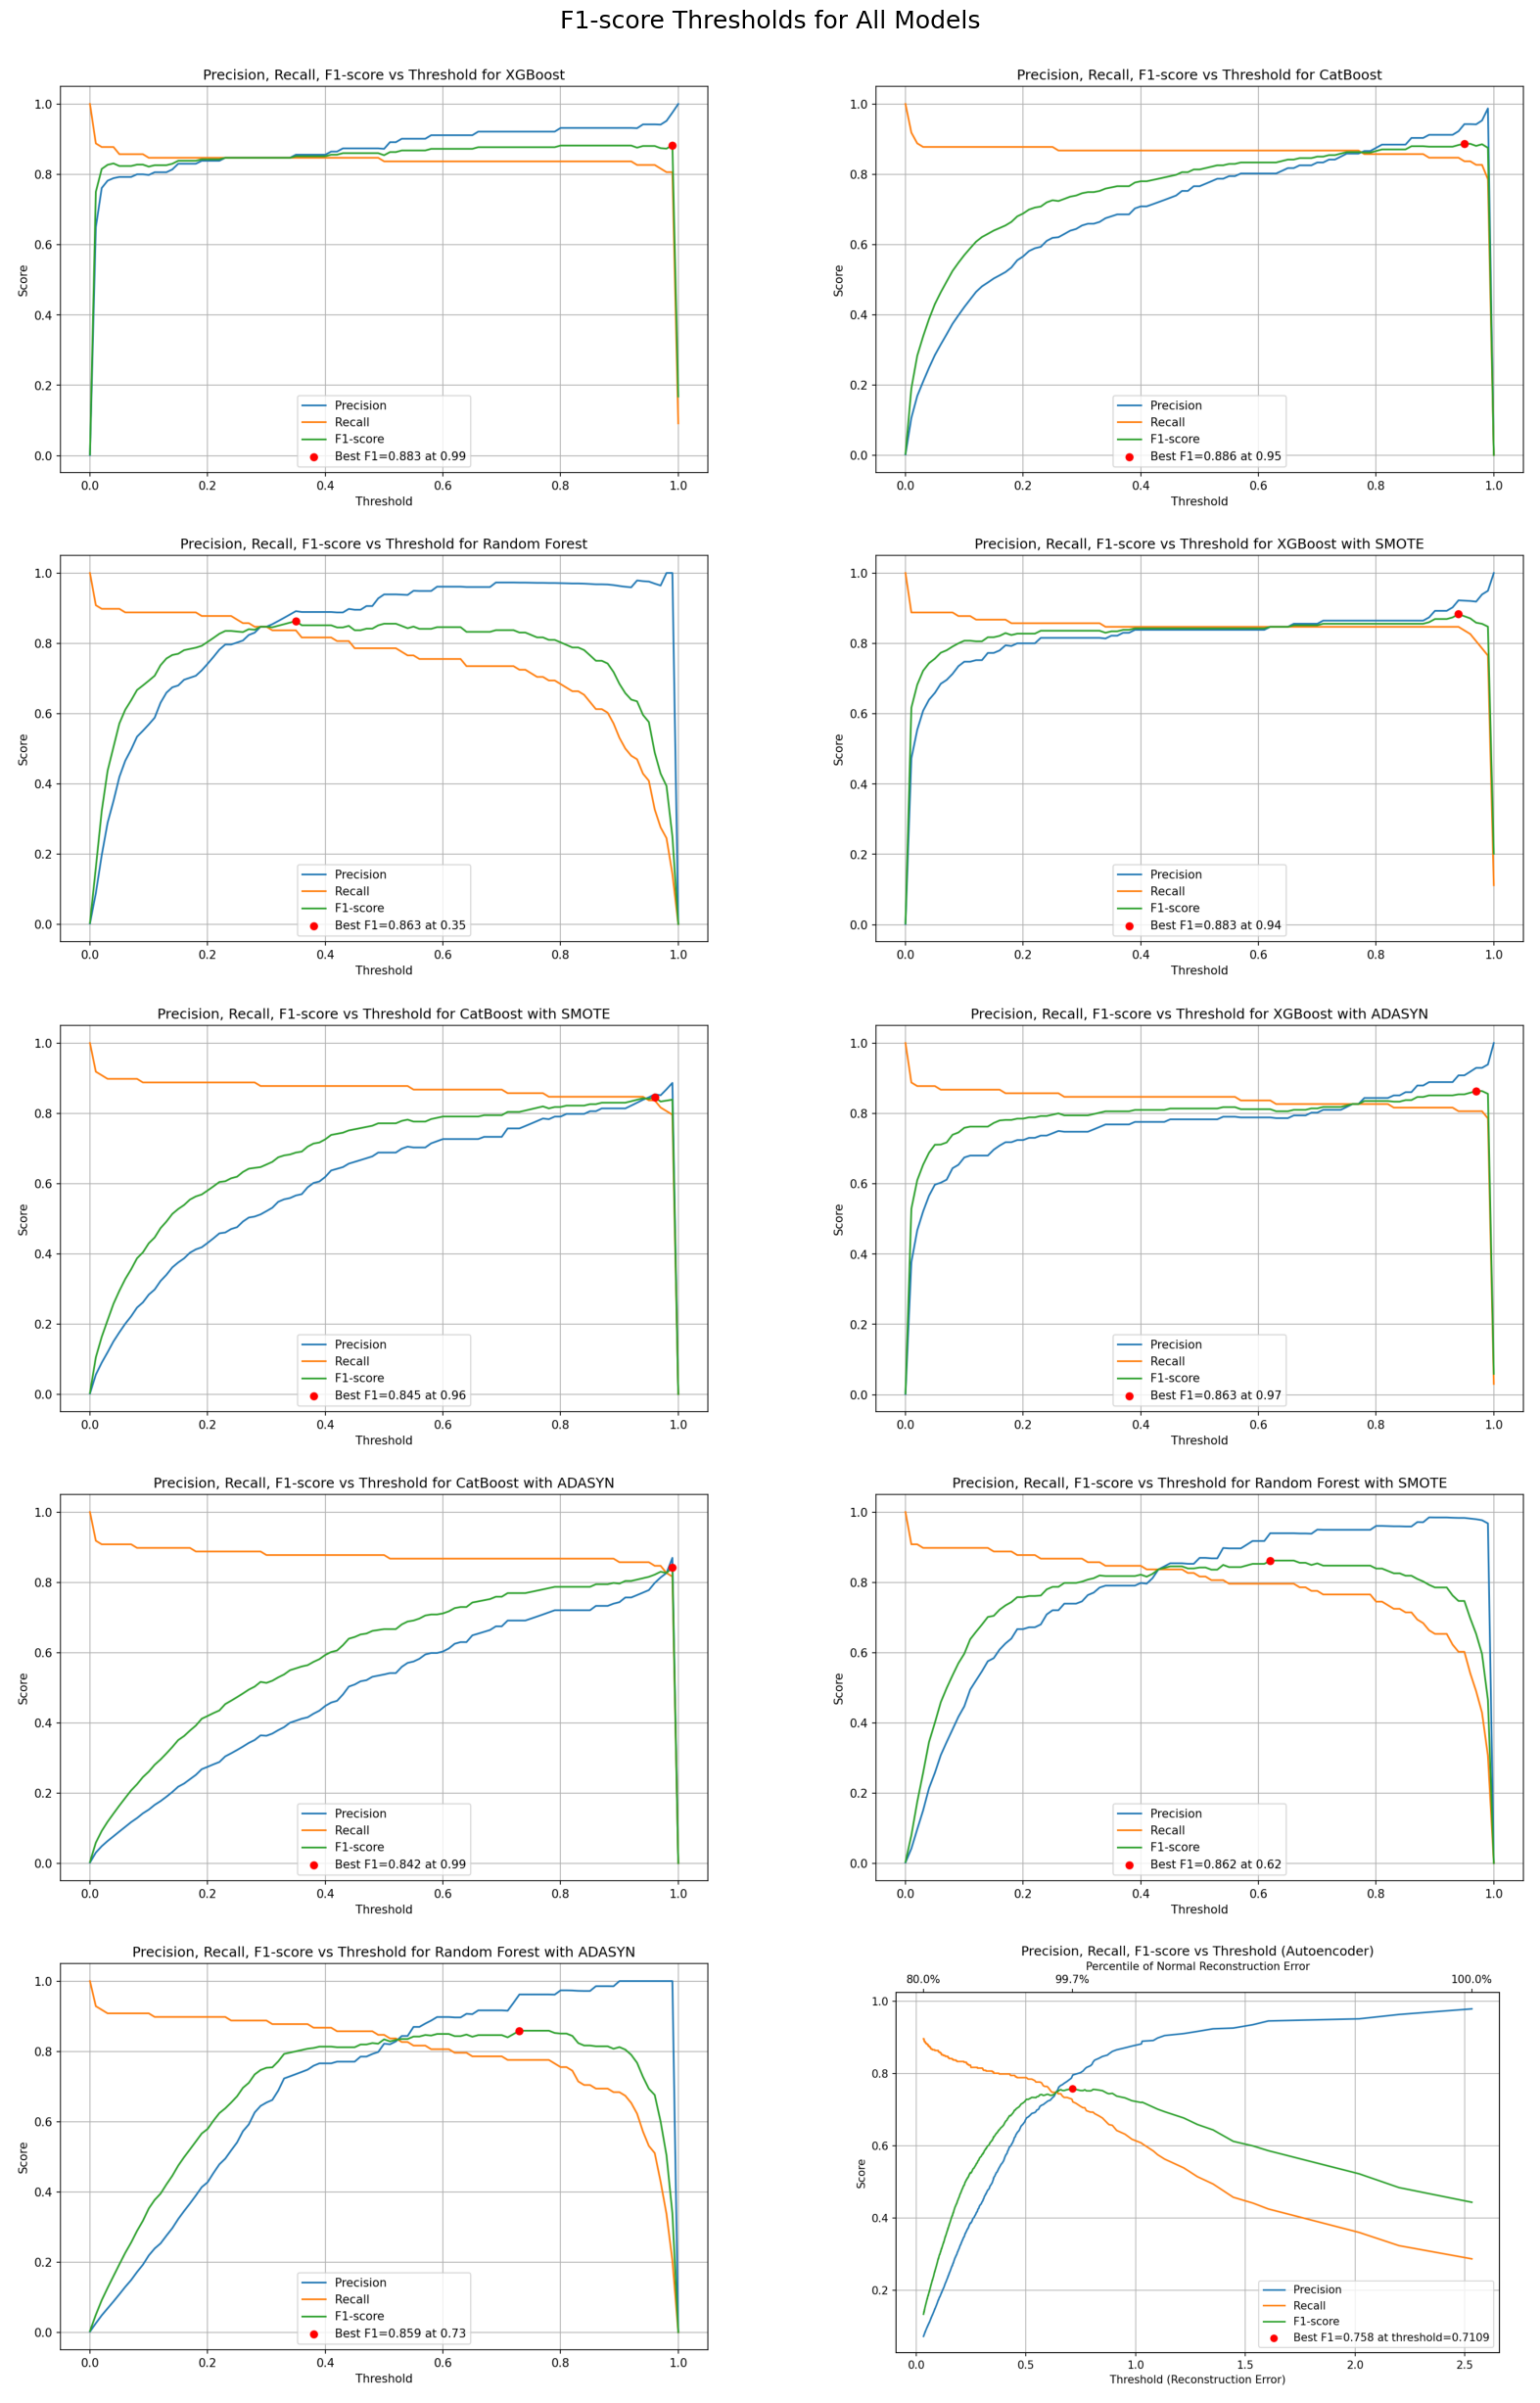

In [69]:
f1_threshold_images = [
    ('../results/f1_threshold/f1_threshold_XGBoost.png'),
    ('../results/f1_threshold/f1_threshold_CatBoost.png'),
    ('../results/f1_threshold/f1_threshold_Random Forest.png'),
    ('../results/f1_threshold/f1_threshold_XGBoost with SMOTE.png'),
    ('../results/f1_threshold/f1_threshold_CatBoost with SMOTE.png'),
    ('../results/f1_threshold/f1_threshold_XGBoost with ADASYN.png'),
    ('../results/f1_threshold/f1_threshold_CatBoost with ADASYN.png'),
    ('../results/f1_threshold/f1_threshold_Random Forest with SMOTE.png'),
    ('../results/f1_threshold/f1_threshold_Random Forest with ADASYN.png'),
    ('../results/f1_threshold/f1_threshold_Autoencoder.png')
]

n = len(f1_threshold_images)
ncols = 2
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(18, 5 * nrows))
axes = axes.flatten()

for i in range(n):
    img_path= f1_threshold_images[i]
    img = mpimg.imread(img_path)
    axes[i].imshow(img)
    axes[i].axis('off')

for i in range(n, len(axes)):
    axes[i].axis('off')

plt.suptitle('F1-score Thresholds for All Models', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()      

### 4.3 Confusion Matrix Analysis

The confusion matrices provide a  breakdown of each model's predictions, showing true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN). 

**What these matrices show:**
- Each matrix displays the count of predictions in each category: TP (correctly identified fraud), TN (correctly identified legitimate transactions), FP (legitimate transactions incorrectly flagged as fraud), and FN (missed fraud).
- The matrices are generated using optimized thresholds (shown in the filenames, e.g., 0.95 for CatBoost), which maximize the F1-score for each model.

**Key observations:**
- **Threshold variation:** The optimal thresholds vary significantly between models, from 0.35 for Random Forest to 0.99 for XGBoost and CatBoost with ADASYN. This reflects differences in how models calibrate their probability estimates.
- **True Negatives:** All models excel at correctly identifying legitimate transactions (high TN count), which is expected given the class imbalance.
- **False Positives vs. False Negatives:** The trade-off between FP and FN differs across models:
  - CatBoost and XGBoost tend to have fewer false negatives (missed frauds) but may have slightly more false positives.
  - Random Forest with its lower threshold (0.35) is more aggressive in flagging potential fraud, resulting in more false positives but fewer missed frauds.
  - The autoencoder shows a different error pattern, with a more balanced distribution between FP and FN.
- **Autoencoder's different methodology:** The autoencoder's confusion matrix shows different counts because it uses a unique approach - it's trained exclusively on non-fraudulent transactions to learn "normal" patterns, then classifies based on reconstruction error. Its test set contains 10% of normal transactions plus all fraud cases, explaining the different class distribution compared to supervised models.


**Practical implications:**
- **Business cost consideration:** In fraud detection, the cost of a false negative (missed fraud) is typically much higher than a false positive (investigating a legitimate transaction). These matrices help stakeholders assess this trade-off for each model.
- **Operational impact:** Models with more false positives require more investigation resources but catch more fraud. The right balance depends on the specific business context and available resources.
- **Model selection:** Beyond overall metrics like F1-score, confusion matrices reveal the specific error patterns of each model, which may influence the final model selection based on business priorities.



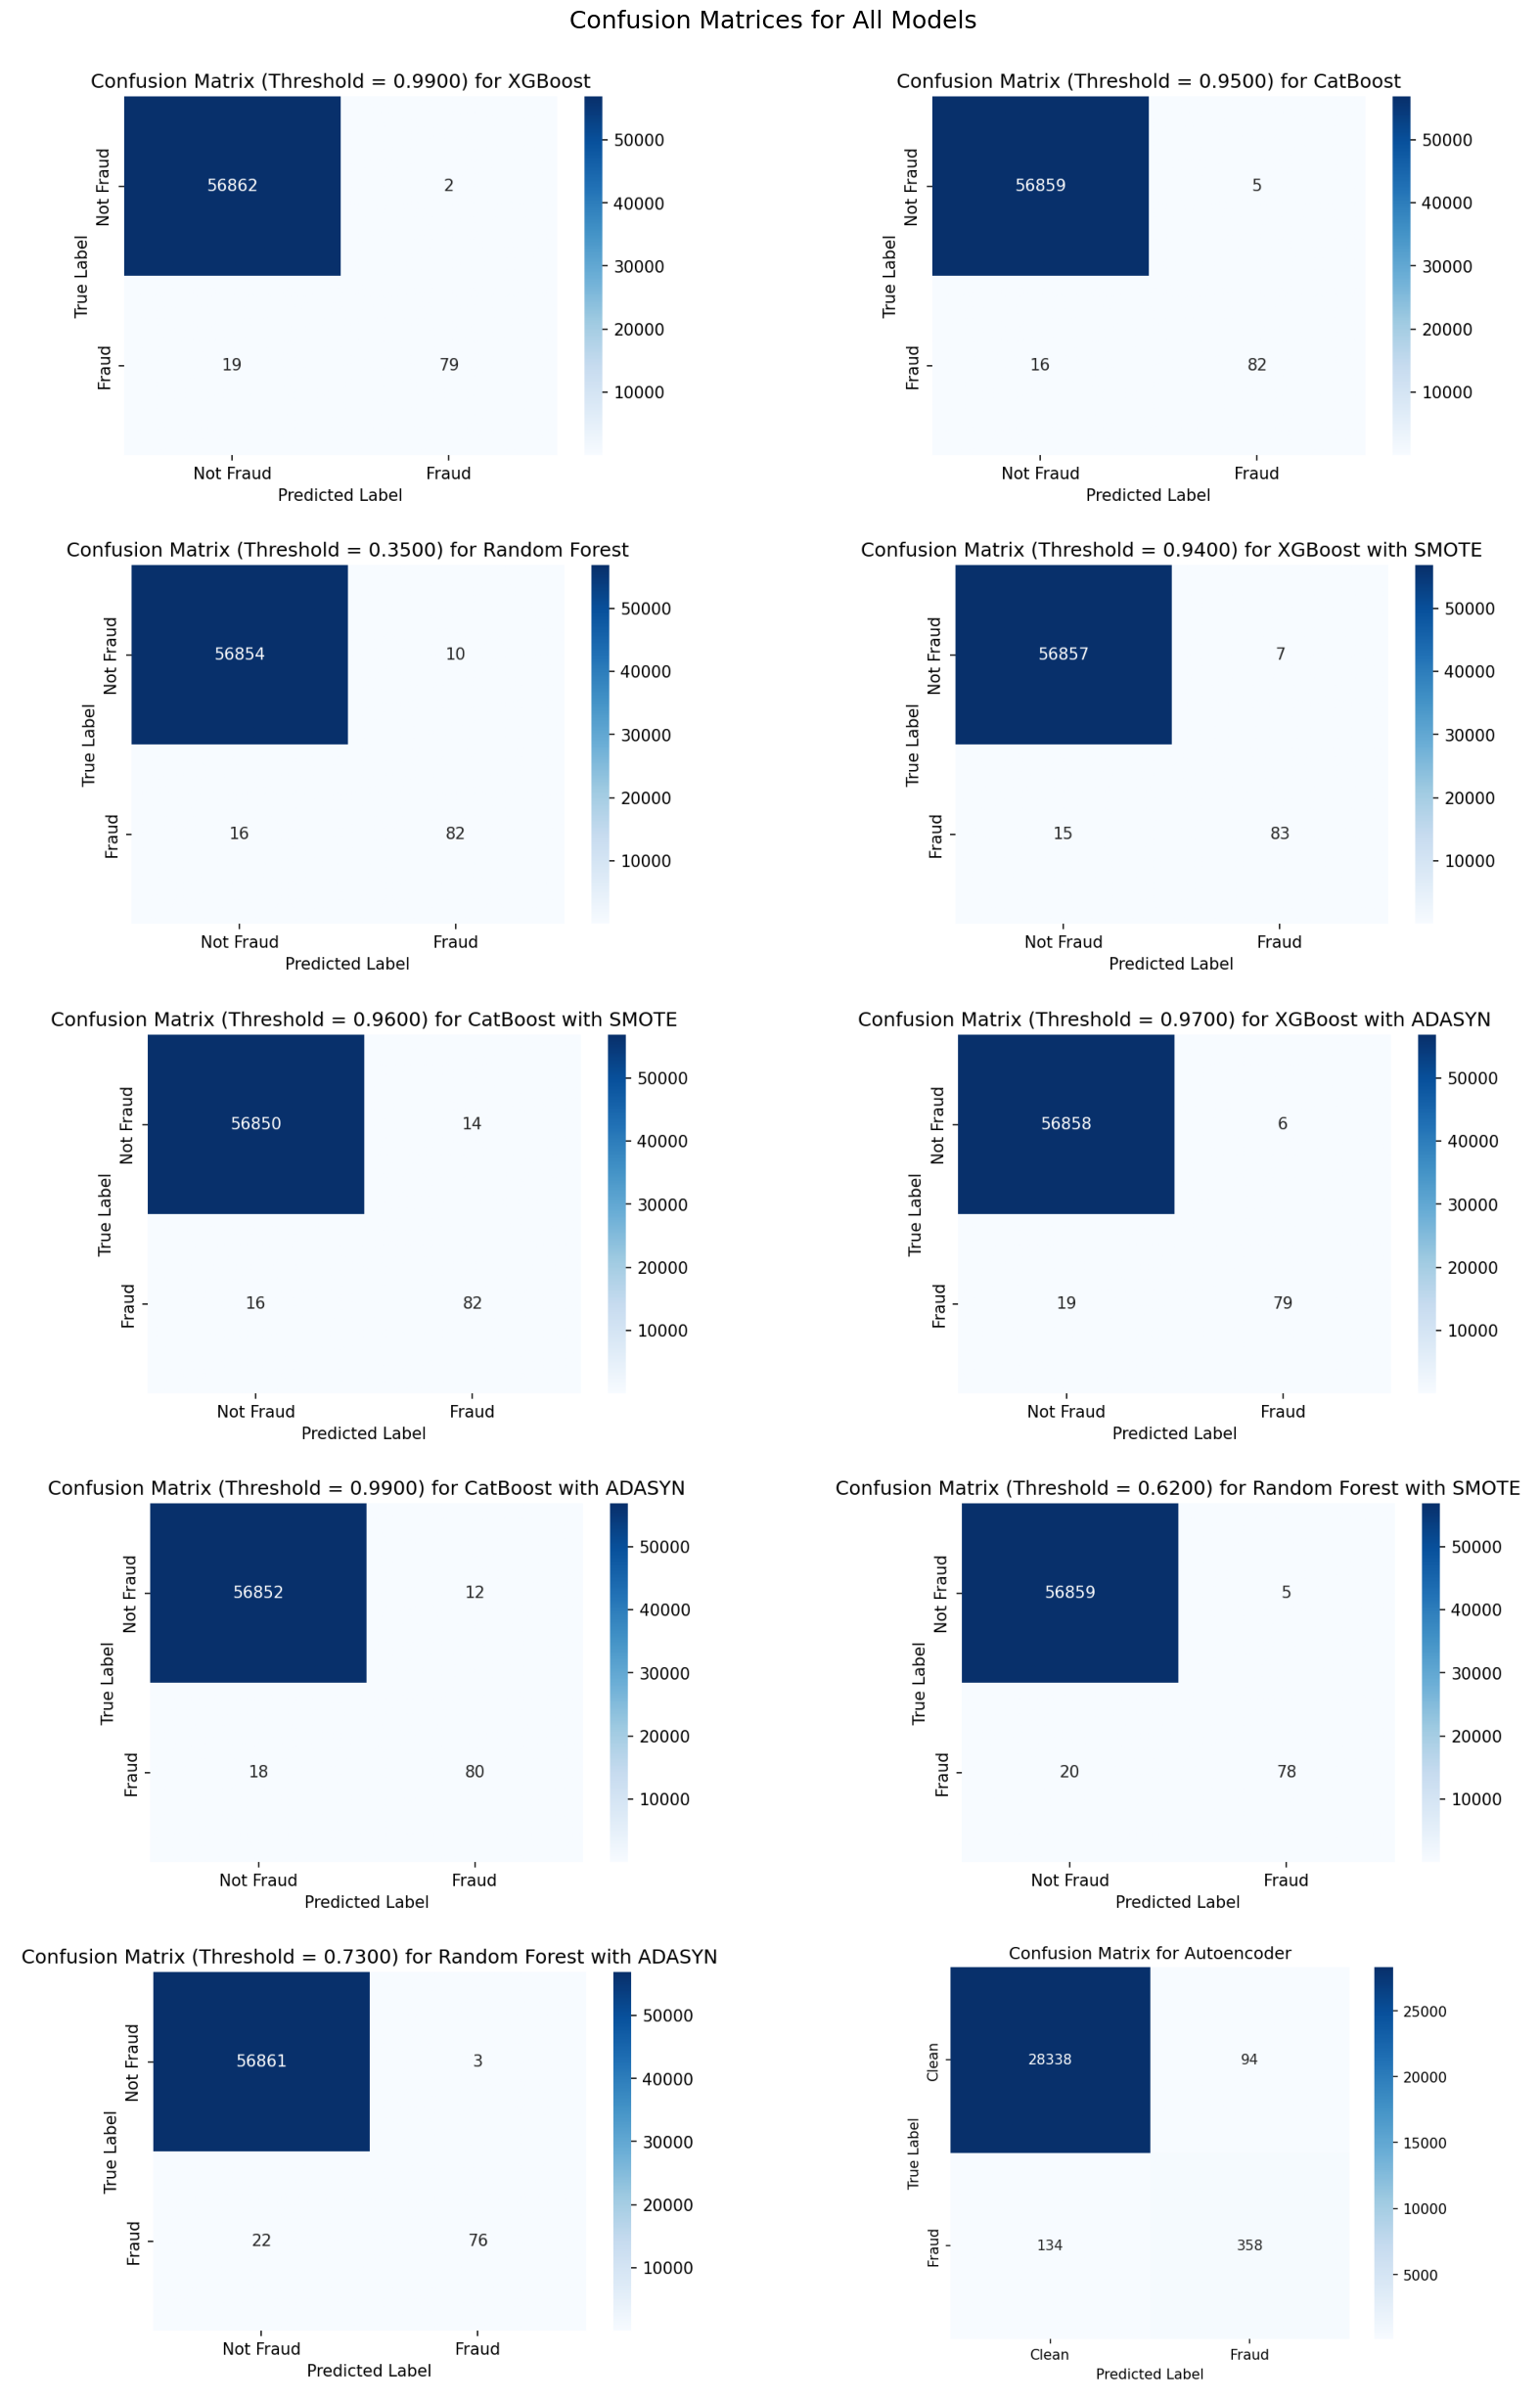

In [73]:
# List of (image_path, display_title)
cm_images = [
    ('../results/confusion_matrix/confusion_matrix_XGBoost_0.9900.png'),
    ('../results/confusion_matrix/confusion_matrix_CatBoost_0.9500.png'),
    ('../results/confusion_matrix/confusion_matrix_Random Forest_0.3500.png'),
    ('../results/confusion_matrix/confusion_matrix_XGBoost with SMOTE_0.9400.png'),
    ('../results/confusion_matrix/confusion_matrix_CatBoost with SMOTE_0.9600.png'),
    ('../results/confusion_matrix/confusion_matrix_XGBoost with ADASYN_0.9700.png'),
    ('../results/confusion_matrix/confusion_matrix_CatBoost with ADASYN_0.9900.png'),
    ('../results/confusion_matrix/confusion_matrix_Random Forest with SMOTE_0.6200.png'),
    ('../results/confusion_matrix/confusion_matrix_Random Forest with ADASYN_0.7300.png'),
    ('../results/confusion_matrix/Autoencoder Confusion Matrix.png')
]

n = len(cm_images)
ncols = 2
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(18, 5 * nrows))
axes = axes.flatten()

for i in range(n):
    img_path= cm_images[i]
    img = mpimg.imread(img_path)
    axes[i].imshow(img)
    axes[i].axis('off')

for i in range(n, len(axes)):
    axes[i].axis('off')

plt.suptitle('Confusion Matrices for All Models', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


### 4.4 ROC Curve Analysis - Class Imbalance Considerations

While the ROC curves show impressive performance across all models, it's important to understand how class imbalance affects these metrics:

**Impact of class imbalance on ROC curves:**
- The high AUC-ROC values (0.94-0.98+) and visually appealing curves are partially influenced by the severe class imbalance in our dataset.
- With fraud transactions representing only 0.17% of all transactions (492 frauds vs. 284,315 legitimate), models can achieve high true negative rates relatively easily.
- This class imbalance can inflate AUC-ROC metrics, as correctly classifying the dominant class (legitimate transactions) heavily influences the overall curve shape.
- A model could achieve a high AUC-ROC by correctly classifying most legitimate transactions while still missing a significant portion of fraud cases.

**Why this matters:**
- In fraud detection, the cost of missing fraud (false negatives) is typically much higher than the cost of investigating legitimate transactions (false positives).
- ROC curves give equal weight to both types of errors, which may not reflect business priorities in fraud detection.
- This is why Precision-Recall curves provide a complementary and often more realistic assessment in highly imbalanced contexts like fraud detection.
- PR curves focus specifically on the positive class (fraud) and are more sensitive to false positive rates in imbalanced datasets.

**Recommended approach:**
- Consider both ROC and PR curves when evaluating models for fraud detection.
- Pay special attention to model performance at business-relevant thresholds rather than overall AUC metrics.

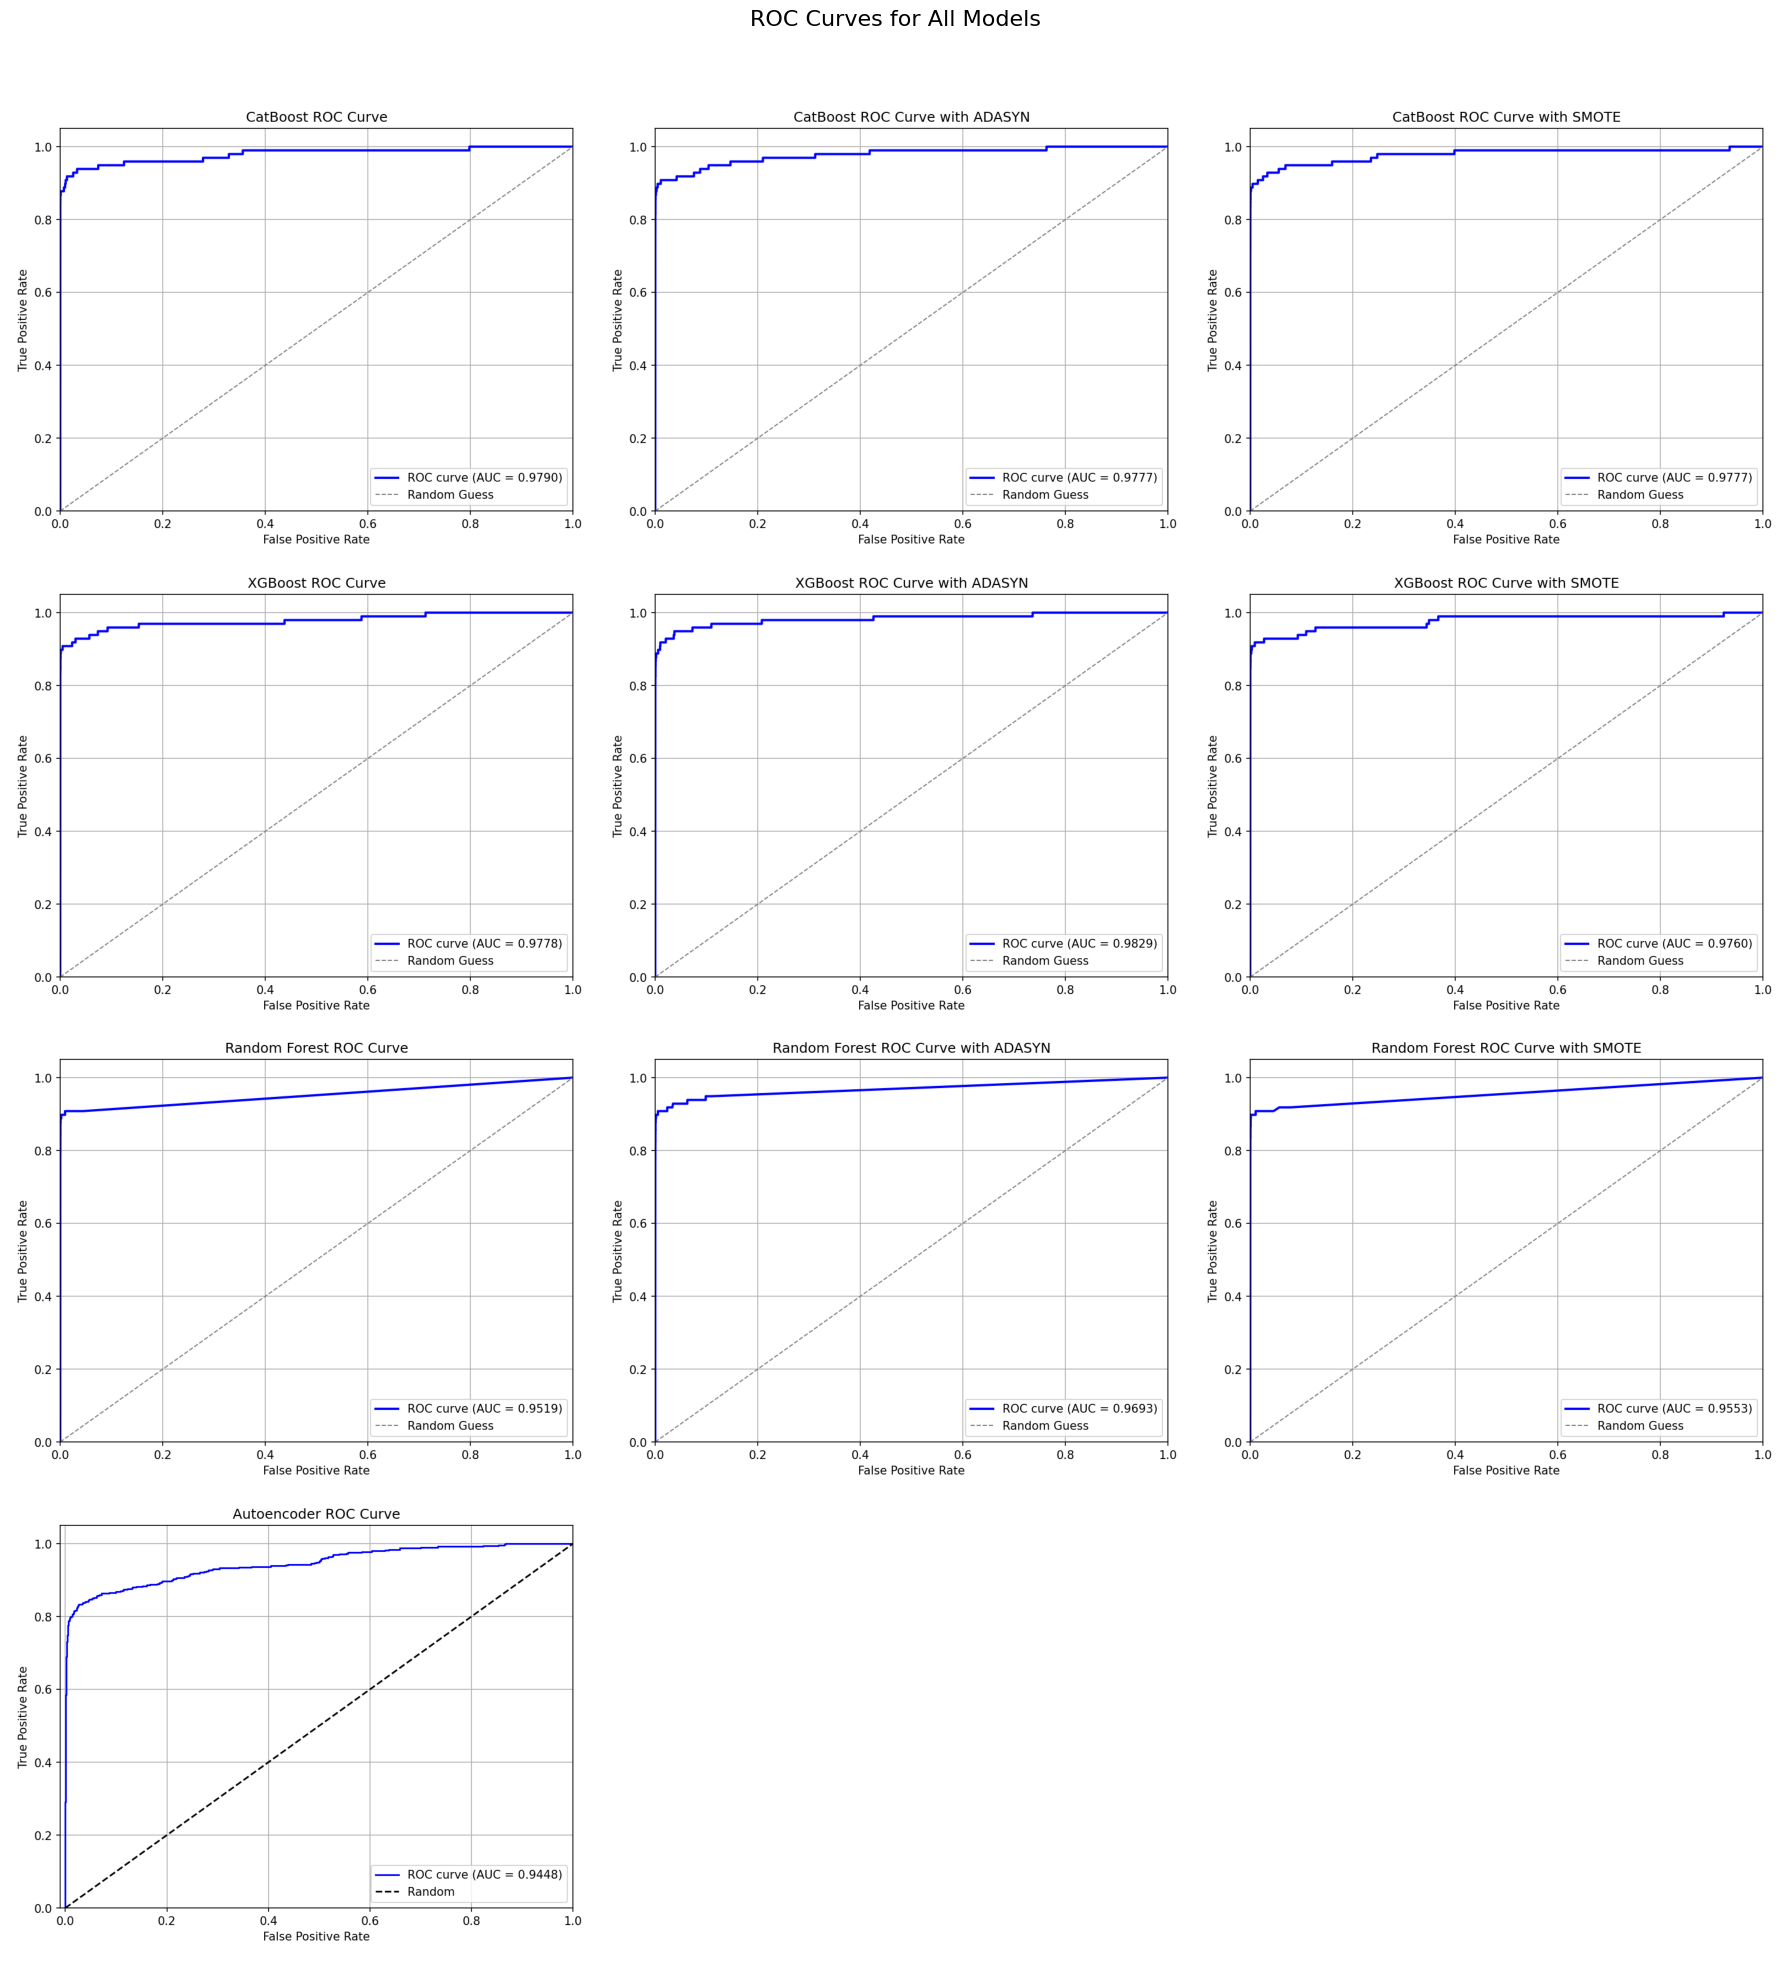

In [ ]:
roc_images = [
    '../results/roc_curve/CatBoost ROC Curve.png',
    '../results/roc_curve/CatBoost ROC Curve with ADASYN.png',
    '../results/roc_curve/CatBoost ROC Curve with SMOTE.png',
    '../results/roc_curve/XGBoost ROC Curve.png',
    '../results/roc_curve/XGBoost ROC Curve with ADASYN.png',
    '../results/roc_curve/XGBoost ROC Curve with SMOTE.png',
    '../results/roc_curve/Random Forest ROC Curve.png',
    '../results/roc_curve/Random Forest ROC Curve with ADASYN.png',
    '../results/roc_curve/Random Forest ROC Curve with SMOTE.png',
    '../results/roc_curve/Autoencoder ROC Curve.png'
]

n = len(roc_images)
ncols = 3
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(18, 5 * nrows))
axes = axes.flatten()

for ax, img_path in zip(axes, roc_images):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')

# Hide any unused subplots
for ax in axes[n:]:
    ax.axis('off')

plt.suptitle('ROC Curves for All Models', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### 4.5 Precision-Recall Curve Analysis

The Precision-Recall (PR) curves visualize the trade-off between precision and recall across different decision thresholds for each model and sampling technique. In highly imbalanced datasets like credit card fraud, PR curves often provide more informative insights than ROC curves.

**What these curves show:**
- The PR curve plots precision (positive predictive value) against recall (sensitivity) at various threshold settings.
- The area under the PR curve (AUC-PR) indicates the model's ability to identify positive cases without generating excessive false alarms.
- Unlike ROC curves, the baseline for PR curves is not fixed but depends on the class distribution (shown as a horizontal dashed line representing the prevalence of fraud).

**Key observations:**
- The PR curves reveal more pronounced differences between models than the ROC curves, highlighting the challenge of maintaining high precision while increasing recall in this imbalanced dataset.
- CatBoost and XGBoost consistently achieve the highest AUC-PR values, demonstrating superior ability to identify fraud while minimizing false positives.
- Random Forest shows good performance but typically with a steeper drop-off in precision as recall increases compared to the boosting models.
- The autoencoder's PR curve shows a different pattern, with generally lower AUC-PR but sometimes maintaining reasonable precision at specific recall levels.
- Sampling techniques show more visible effects on PR curves than on ROC curves, sometimes improving performance in specific recall ranges but not necessarily across the entire curve.

**Practical implications:**
- PR curves are particularly valuable in fraud detection due to the high cost of false negatives and the operational impact of false positives.
- The steep decline in precision at higher recall levels illustrates the fundamental challenge in fraud detection: catching more fraud inevitably leads to more false alarms.
- These curves help stakeholders select thresholds that balance business priorities, such as investigation capacity (affected by false positives) and fraud loss prevention (affected by false negatives).
- Models with higher AUC-PR generally provide better operational efficiency by requiring fewer investigations to catch the same amount of fraud.

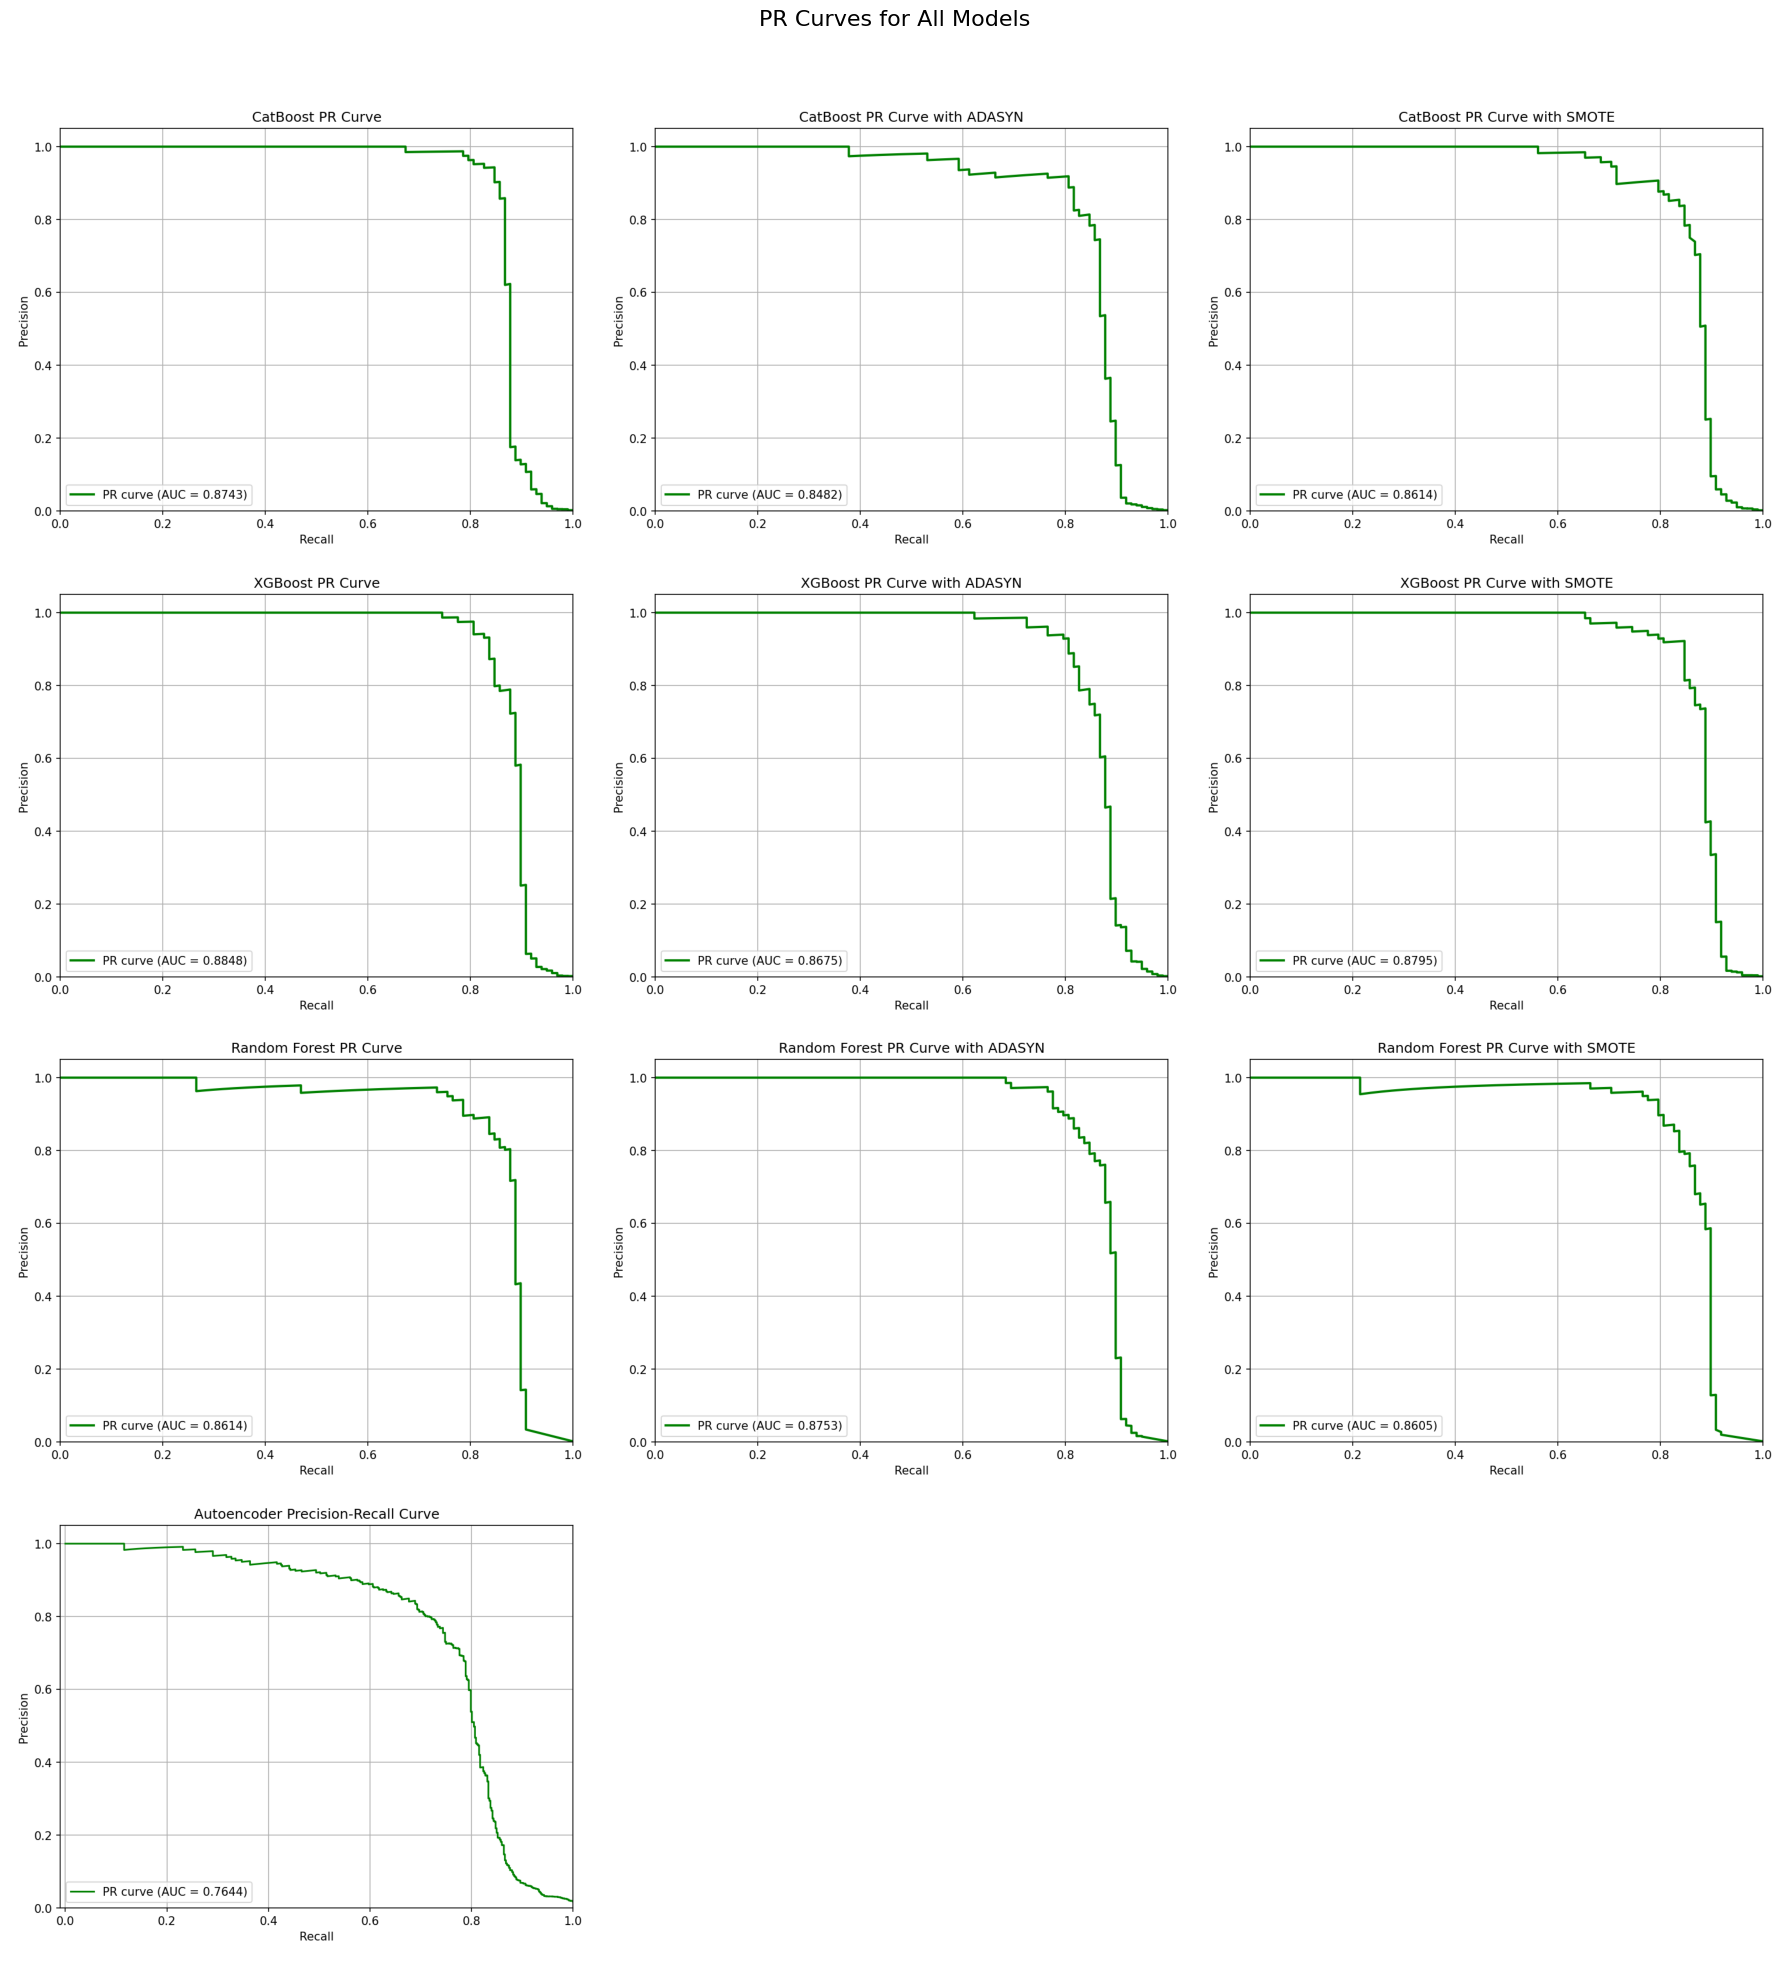

In [47]:
pr_images = [
    '../results/pr_curve/CatBoost PR Curve.png',
    '../results/pr_curve/CatBoost PR Curve with ADASYN.png',
    '../results/pr_curve/CatBoost PR Curve with SMOTE.png',
    '../results/pr_curve/XGBoost PR Curve.png',
    '../results/pr_curve/XGBoost PR Curve with ADASYN.png',
    '../results/pr_curve/XGBoost PR Curve with SMOTE.png',
    '../results/pr_curve/Random Forest PR Curve.png',
    '../results/pr_curve/Random Forest PR Curve with ADASYN.png',
    '../results/pr_curve/Random Forest PR Curve with SMOTE.png',
    '../results/pr_curve/Autoencoder PR Curve.png'
]

n = len(pr_images)
ncols = 3
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(18, 5 * nrows))
axes = axes.flatten()

for ax, img_path in zip(axes, pr_images):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')

# Hide any unused subplots
for ax in axes[n:]:
    ax.axis('off')

plt.suptitle('PR Curves for All Models', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 5. Conclusion and Recommendations

This comprehensive analysis of various fraud detection approaches provides valuable insights for implementing an effective fraud detection system. Here are the key takeaways and recommendations:

**Key Findings:**
1. **Model Performance Hierarchy:**
   - CatBoost and XGBoost consistently outperform other models across most metrics.
   - Random Forest provides solid performance with potentially better interpretability.
   - The autoencoder demonstrates the viability of unsupervised approaches, achieving respectable performance without labeled data.

2. **Class Imbalance Handling:**
   - Sampling techniques (SMOTE, ADASYN) show mixed results, with benefits varying by model and metric.
   - For boosting models, the native handling of class imbalance often performs comparably to explicit resampling.
   - The optimal approach depends on specific business priorities (minimizing false negatives vs. false positives).

3. **Threshold Optimization:**
   - Default classification thresholds (0.5) are rarely optimal for fraud detection.
   - F1-threshold analysis reveals significant performance improvements through threshold tuning.
   - The optimal threshold varies substantially between models and should be selected based on business constraints.

4. **Visualization Insights:**
   - t-SNE plots confirm the presence of discriminative patterns in both original and reconstructed feature spaces.
   - ROC and PR curves highlight the superior discrimination ability of boosting models.
   - Confusion matrices reveal different error patterns across models, informing operational considerations.

**Recommendations:**
1. **Primary Model Selection:** Implement CatBoost or XGBoost as the primary fraud detection model, with the final choice depending on:
   - Computational constraints (training and inference time)
   - Interpretability requirements
   - Ease of deployment and maintenance

2. **Threshold Strategy:** Develop a dynamic threshold strategy that:
   - Starts with the optimal F1-score threshold identified in this analysis
   - Allows for periodic recalibration as fraud patterns evolve
   - Potentially implements different thresholds for different transaction segments

3. **Complementary Approaches:**
   - Consider implementing the autoencoder as a complementary system, especially for:
     - Detecting novel fraud patterns not present in historical labeled data
     - Providing an additional signal that could be combined with supervised model outputs
     - Serving as a backup when labeled data quality is questionable

4. **Future Enhancements:**
   - Explore ensemble methods combining multiple models to leverage their complementary strengths
   - Investigate more sophisticated feature engineering approaches
   - Consider temporal aspects of fraud detection through sequence models or time-based features
   - Implement continuous monitoring of model performance to detect concept drift

In conclusion, this fraud detection project demonstrates that while supervised tree-based models (particularly boosting algorithms) provide the best overall performance, a multi-faceted approach incorporating both supervised and unsupervised techniques offers the most robust solution for real-world fraud detection challenges.
